# Running predictions on new ugis
13th Apr

Notebook for training ensemble of random forest models with MPNN hidden state vectors on new + old activity data and running prediction on new prospective molecules

Let's load the moonshot data first

In [2]:
import pandas as pd
import numpy as np
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import MolFromSmiles, MolToSmiles

def canon_tautomers(smiles_list):
    enumerator = rdMolStandardize.TautomerEnumerator()

    smiles_list = [MolToSmiles(enumerator.Canonicalize(
        MolFromSmiles(smi))) for smi in smiles_list]

    return smiles_list


def read_and_process_dataframe(path_to_dataframe, canonicalize_tautomers=True, IC50_threshold=None, pIC50_threshold=None):
    df = pd.read_csv(path_to_dataframe)

    if canonicalize_tautomers:
        df['SMILES'] = canon_tautomers(df['SMILES']) 

    # assign IC50 of 100 to inactives
    df.loc[df['IC50'].astype(str).str.contains('>'), 'IC50'] = 100.0
    df.loc[df['IC50'].isnull(), 'IC50'] = 100.0
    
    df['IC50'] = df['IC50'].astype(float)
    df['pIC50'] = -np.log10(df['IC50'].to_numpy()) + 6

    indicies_of_actives = df[df['IC50'] != 100.0].index.to_numpy()
    
    if IC50_threshold is not None:
        df = df.query('IC50 < @IC50_threshold')
    if pIC50_threshold is not None:
        df = df.query('pIC50 >= @pIC50_threshold')

    pIC50_values = df['pIC50'].to_numpy()

    return df, pIC50_values, indicies_of_actives

moonshot_data_dir = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/moonshot_evaluation_sets/'
file_names = ['combined_acid.csv', 'combined_aldehyde.csv', 'combined_amine.csv', 'combined_isocyanide.csv']
file_names = [f'{moonshot_data_dir}{file}' for file in file_names]
file_names.append(
    '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/new_ugi_activity_2022_04_03.csv')

list_of_dataframes = []
list_of_pIC50_values = []
list_of_active_indices = []

for file in file_names:

    df_for_this_file, y_train, indicies_of_actives = read_and_process_dataframe(file)

    list_of_dataframes.append(df_for_this_file)
    list_of_pIC50_values.append(y_train)
    list_of_active_indices.append(indicies_of_actives)


RDKit WARNING: [10:57:02] Tautomer enumeration stopped at 207 tautomers: max transforms reached
[10:57:02] Tautomer enumeration stopped at 207 tautomers: max transforms reached
RDKit WARNING: [10:57:04] Tautomer enumeration stopped at 229 tautomers: max transforms reached
[10:57:04] Tautomer enumeration stopped at 229 tautomers: max transforms reached


Generate fingerprints

In [3]:
from useful_rdkit_utils import add_molecule_and_errors, mol2numpy_fp
from dock2hit.generate_mpnn_fps import generate_mpnn_fps_from_dataframe

taut_model='/rds-d2/user/wjm41/hpc-work/models/dock2hit/ugi/ugi_taut/model_mol9039221.ckpt'

names = ['acid', 'aldehyde', 'amine', 'isocyanide', 'new']
for name, df in zip(names, list_of_dataframes):
    add_molecule_and_errors(df, mol_col_name='mol')
    df['morgan_fp'] = df['mol'].apply(mol2numpy_fp)
    df['mpnn_fp'] = [x for x in generate_mpnn_fps_from_dataframe(df, load_name=taut_model)]
    df['df'] = name

df_all = pd.concat(list_of_dataframes).reset_index()
df_all['IC50'] = df_all['IC50'].astype(float)


INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
100%|██████████| 5/5 [03:56<00:00, 47.39s/it]


New compounds to test from Alpha (4th Apr)

In [4]:
new_test_mols = ['CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1ccns1)c1cccnc1)C(=O)c1cocn1', # this one is the top hit so far
                'O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4',
                 'O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4',
                 ]

test_df = pd.DataFrame(new_test_mols, columns=['SMILES'])


Run predictions on new molecules

In [39]:
from tqdm import tqdm
from dock2hit.fine_tuning.model_fitting import fit_forest

def merge_ensemble_of_score_dfs(list_of_dfs, names_of_scores):
    df_merged = pd.concat(list_of_dfs, axis=1)
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
    df_merged['pred_mean'] = np.mean(df_merged[names_of_scores], axis=1)
    df_merged['pred_std'] = np.std(df_merged[names_of_scores], axis=1)
    return df_merged.sort_values(by='pred_mean', ascending=False)

def run_prediction_on_dataframe(df, 
                                model, 
                                load_name: str, 
                                input_rep: str = 'mpnn_fp',
                                savename: str = None, 
                                canon: bool = False, 
                                uncertain: bool = False):

    df_score = df.copy()
    if canon:
        # already done so just save some time lmao
        df_score['SMILES'] = canon_tautomers(df_score['SMILES'])
    if input_rep == 'mpnn_fp':
        x_new = generate_mpnn_fps_from_dataframe(df_score, load_name=load_name)
    else:
        add_molecule_and_errors(df_score, mol_col_name='mol')
        # x_new = df_score['mol'].apply(mol2numpy_fp).values
        x_new = [x for x in df_score['mol'].apply(mol2numpy_fp)]

    if uncertain:
        preds, var = model.predict(x_new, no_var=False)
        df_score['predicted_var'] = var
    else:
        # print(x_new)
        preds = model.predict(x_new)

    df_score['predicted_pIC50'] = preds
    # df_score = df_score.sort_values(by='predicted_pIC50', ascending=False)

    if savename:
        df_score.to_csv(savename, index=False)
    return df_score

print('Fitting RF models')

n_models = 5

old_model = '/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
tautomer_mpnn = '/rds-d2/user/wjm41/hpc-work/models/dock2hit/ugi/ugi_taut/model_mol9039221.ckpt'

def train_and_score(df_to_score, input_rep: str ='mpnn_fp'):
    list_of_score_dfs = []
    list_of_score_names = []
    for n in tqdm(range(n_models)):
        score_name = 'score_'+str(n)
        list_of_score_names.append(score_name)
        x = np.vstack(df_all['mpnn_fp'].to_numpy())
        random_forest_trained_on_all_data = fit_forest(
            np.vstack(df_all[input_rep].to_numpy()), df_all['pIC50'].to_numpy())
        
        
        df_with_predictions = run_prediction_on_dataframe(
            df_to_score, model=random_forest_trained_on_all_data, input_rep = input_rep, load_name=tautomer_mpnn)
        df_with_predictions.rename(
            columns={'predicted_pIC50': score_name}, inplace=True)
        list_of_score_dfs.append(df_with_predictions)
        
    df_mean = merge_ensemble_of_score_dfs(
        list_of_score_dfs, names_of_scores=list_of_score_names)
    return df_mean

df_training_set = train_and_score(df_all, input_rep='mpnn_fp').rename(columns={'pred_mean': 'mpnn_pred_mean'})
df_training_set['morgan_pred_mean'] = train_and_score(df_all, input_rep='morgan_fp').rename(
    columns={'pred_mean': 'morgan_pred_mean'})['morgan_pred_mean']

df_new_mols = train_and_score(test_df, input_rep='mpnn_fp')

Fitting RF models
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 383, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 4, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1191, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 567, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 2, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1853, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 383, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 1, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates,

New values

In [6]:
pd.set_option('display.max_colwidth', 1000)
df_mean.sort_values(by='pred_mean', ascending=False)


,SMILES,pred_mean,pred_std
0,CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1ccns1)c1cccnc1)C(=O)c1cocn1,5.499362,0.175849
1,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4,5.315284,0.073589
2,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4,5.271943,0.047230
3,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4,5.140188,0.214933
5,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4,5.109158,0.131860
6,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4,4.980122,0.047702
4,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4,4.950834,0.187341


Old values (output from previous notebook 8th Apr) - new data does increase the predicted potency for some of the molecules (but not all)

In [20]:
pd.set_option('display.max_colwidth', 1000)
df_mean.sort_values(by='pred_mean', ascending=False)


,SMILES,pred_mean,pred_std
0,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4,5.041475,0.139373
2,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4,5.011526,0.111470
1,O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4,4.993751,0.104332
3,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4,4.891255,0.091191
4,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4,4.843136,0.086849
5,O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4,4.763236,0.133717


In [13]:
import mols2grid

mols2grid.display(df_mean,
                  smiles_col='SMILES',
                  subset=['img', 'pred_mean', 'pred_std'],
                  transform={"pred_mean": lambda x: f"mean predicted pIC50: {x:.3f}", 
                             'pred_std': lambda x: f"stdev pIC50: {x:.3f}"},
                  tooltip=["SMILES"],
                  useSVG=True,
                  use_coords=True,
                  selection=True,
                  n_rows=5,
                  size=(240, 260),
                  width='100%')


IC50 of existing data:

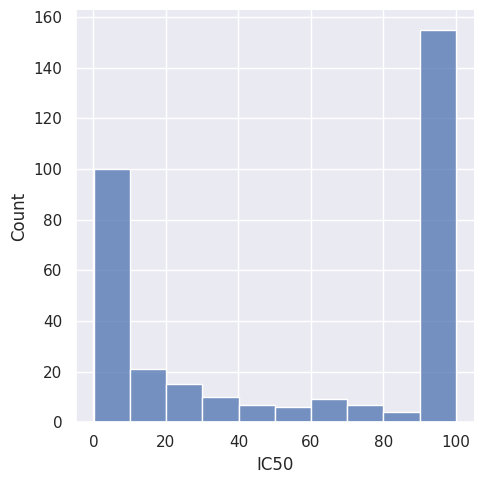

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.dpi":100})

sns.displot(data = df_all, x="IC50",  multiple="dodge", bins=10)

plt.show()

In [52]:
import plotly.express as px
import molplotly

df_training_set['predicted_IC50_mpnn_fp'] = np.power(10, -(df_training_set['mpnn_pred_mean']-6))
df_training_set['predicted_IC50_morgan_fp'] = np.power(10, -(df_training_set['morgan_pred_mean']-6))

fig_scatter = px.scatter(df_training_set.query('df != "new"'),
                         x='IC50',
                         y='predicted_IC50_mpnn_fp',
                         log_x=True,
                         log_y=True,
                         height=800,
                         title='IC50 predictions for all molecules')
fig_scatter_morgan = px.scatter(df_training_set.query('df != "new"'),
                         x='IC50',
                         y='predicted_IC50_morgan_fp',
                         color_discrete_sequence=['red'],
                         log_x=True,
                         log_y=True)

fig_scatter['data'][0]['showlegend']=True
fig_scatter['data'][0]['name'] = 'mpnn_fp'
fig_scatter_morgan['data'][0]['showlegend']=True
fig_scatter_morgan['data'][0]['name']='morgan_fp'

fig_scatter.add_trace(fig_scatter_morgan.data[0])
fig_scatter.add_shape(type='line', 
                      x0=0.1,
                      x1=100,
                      y0=0.1,
                      y1=100,
                      line=dict(color='black', dash='dash'))
fig_scatter.show()

# fig_strip = px.strip(df_all,
#                      y='IC50',
#                      hover_name='SMILES',
#                      log_y=True,
#                      width=1000,
#                      height=800)

# fig_strip.show()
# app_strip = molplotly.add_molecules(fig=fig_strip,
#                                     df=df_all,
#                                     smiles_col='SMILES',
#                                     title_col='SMILES',
#                                     wrap=True,
#                                     wraplen=25,
#                                     width=150,
#                                     show_coords=True)

# app_strip.run_server(port=8070)


Check the (training set) regression metrics - only on old molecules?

In [50]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

def print_regression_metrics(scored_dataframe, query_string, input_rep, data_name):

    r2_training_set = r2_score(scored_dataframe.query(query_string)[
                            'IC50'], df_training_set.query(query_string)[f'predicted_IC50_{input_rep}'])
    rho_training_set = spearmanr(scored_dataframe.query(query_string)[
                            'IC50'], df_training_set.query(query_string)[f'predicted_IC50_{input_rep}'])[0]

    print(f'R2 score on {data_name} ({input_rep}): {r2_training_set:.3f}')
    print(f'rho score on {data_name} ({input_rep}): {rho_training_set:.3f}')
    return

training_set_old = 'df != "new"'

print_regression_metrics(df_training_set, query_string=training_set_old, input_rep='mpnn_fp', data_name='training set (old mols)')
print_regression_metrics(df_training_set, query_string=training_set_old, input_rep='morgan_fp', data_name='training set (old mols)')


R2 score on training set (old mols) (mpnn_fp): 0.371
rho score on training set (old mols) (mpnn_fp): 0.799
R2 score on training set (old mols) (morgan_fp): 0.040
rho score on training set (old mols) (morgan_fp): 0.746


What about just active molecules?

In [51]:
active_query = 'df != "new" & IC50 < 90'

print_regression_metrics(df_training_set, query_string=active_query, input_rep='mpnn_fp', data_name='training set (old & active mols)')
print_regression_metrics(df_training_set, query_string=active_query, input_rep='morgan_fp', data_name='training set (old & active mols)')


R2 score on training set (old & active mols) (mpnn_fp): 0.547
rho score on training set (old & active mols) (mpnn_fp): 0.808
R2 score on training set (old & active mols) (morgan_fp): 0.416
rho score on training set (old & active mols) (morgan_fp): 0.665


Let's train on only the actives

In [53]:
active_query = 'df != "new" & IC50 < 90'

df_active = df_all.query(active_query)

df_active_set = train_and_score(df_active, input_rep='mpnn_fp').rename(columns={'pred_mean': 'mpnn_pred_mean'})
df_active_set['morgan_pred_mean'] = train_and_score(df_active, input_rep='morgan_fp').rename(
    columns={'pred_mean': 'morgan_pred_mean'})['morgan_pred_mean']

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 897, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1412, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1926, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 1, 'bootstrap': False}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1889, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 1816, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [54]:
df_active_set['predicted_IC50_mpnn_fp'] = np.power(
    10, -(df_active_set['mpnn_pred_mean']-6))
df_active_set['predicted_IC50_morgan_fp'] = np.power(
    10, -(df_active_set['morgan_pred_mean']-6))

fig_scatter = px.scatter(df_active_set.query('df != "new"'),
                         x='IC50',
                         y='predicted_IC50_mpnn_fp',
                         log_x=True,
                         log_y=True,
                         height=800,
                         title='IC50 predictions for only active molecules')
                         
fig_scatter_morgan = px.scatter(df_active_set.query('df != "new"'),
                                x='IC50',
                                y='predicted_IC50_morgan_fp',
                                color_discrete_sequence=['red'],
                                log_x=True,
                                log_y=True)

fig_scatter['data'][0]['showlegend'] = True
fig_scatter['data'][0]['name'] = 'mpnn_fp'
fig_scatter_morgan['data'][0]['showlegend'] = True
fig_scatter_morgan['data'][0]['name'] = 'morgan_fp'

fig_scatter.add_trace(fig_scatter_morgan.data[0])
fig_scatter.add_shape(type='line',
                      x0=0.1,
                      x1=100,
                      y0=0.1,
                      y1=100,
                      line=dict(color='black', dash='dash'))
fig_scatter.show()


Proper Leave-One-Out splitting